In [0]:
# install java libs and spark.
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
! wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
! tar xf spark-2.4.4-bin-hadoop2.7.tgz
! pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

### Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Install pyspark

In [0]:
pip install pyspark

     |████████████████████████████████| 217.8MB 58kB/s 
     |████████████████████████████████| 204kB 34.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=cd1854947d23411faabb6012324dc1fb65100e8d9ac3d144e6e1dd843d96b3a9
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


### Load Libraries

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Start Spark Session

In [0]:
APP_NAME = "EDA1"
SPARK_URL = "local[*]"

In [0]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()

### Load Data

In [0]:
df = spark.read.json('/content/drive/My Drive/Movies_and_TV.json.gz')

In [0]:
### Get Columns needed
df = df.select('overall', 'reviewText', 'summary')
df.show(5)

+-------+--------------------+--------------------+
|overall|          reviewText|             summary|
+-------+--------------------+--------------------+
|    5.0|really happy they...|               great|
|    5.0|Having lived in W...|Realistic and Acc...|
|    5.0|Excellent look in...|         Peace Child|
|    5.0|More than anythin...|Culturally releva...|
|    4.0|This is a great m...|Good Movie! Great...|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
### Number of null values by column 
print('Null reviewText:', df.where((df["reviewText"].isNull())).count())
print('Null overall:', df.where((df["overall"].isNull())).count())
print('Null summary:',df.where((df["summary"].isNull())).count())

Null reviewText: 8023
Null overall: 0
Null summary: 2189


In [0]:
### Drop na values
df = df.na.drop()
df.count()

8755633

### Graphical Representation of overall column 

In [0]:
### Get overall Count
o_count = df.groupBy("overall").count()
o_count.show()

+-------+-------+
|overall|  count|
+-------+-------+
|    1.0| 632711|
|    4.0|1496685|
|    3.0| 735541|
|    2.0| 406700|
|    5.0|5483996|
+-------+-------+



In [0]:
### Convert to pandas 
plot_df = o_count.toPandas()
plot_df.head()

,overall,count
0,1.0,632711
1,4.0,1496685
2,3.0,735541
3,2.0,406700
4,5.0,5483996


Text(0.5, 1.0, 'Overall Count')

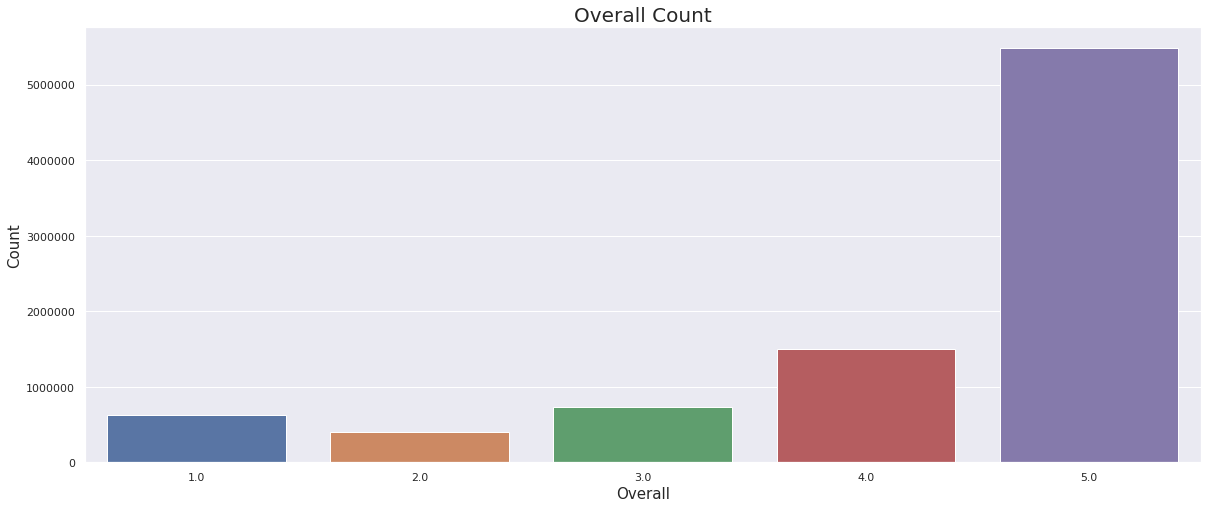

In [0]:
### plot 
sns.set()
plt.figure(figsize=(20,8))
sns.barplot(data = plot_df, x = 'overall', y = 'count')
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Overall',fontsize = 15)
plt.title('Overall Count',fontsize = 20)

### Categorize the length of reviews


In [0]:
### Function to clean text to get better count
def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, "^rt ", "")
  c = regexp_replace(c, "[\=.]"," ")
  c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "")
  c = regexp_replace(c, "  ", " ")
  c = regexp_replace(c, "   ", " ")
  return(c)

In [0]:
### Clean Review Text 
df = df.withColumn("clean_text", clean_text(df["reviewText"]))
df.show(5)

+-------+--------------------+--------------------+--------------------+------+
|overall|          reviewText|             summary|          clean_text|Length|
+-------+--------------------+--------------------+--------------------+------+
|    5.0|really happy they...|               great|really happy they...|    38|
|    5.0|Having lived in W...|Realistic and Acc...|having lived in w...|    42|
|    5.0|Excellent look in...|         Peace Child|excellent look in...|    31|
|    5.0|More than anythin...|Culturally releva...|more than anythin...|    36|
|    4.0|This is a great m...|Good Movie! Great...|this is a great m...|    33|
+-------+--------------------+--------------------+--------------------+------+
only showing top 5 rows



In [0]:
### Create Length Column 
df = df.withColumn("Length", size(split(df['clean_text'], ' ')))
df.show()

+-------+--------------------+--------------------+--------------------+------+
|overall|          reviewText|             summary|          clean_text|Length|
+-------+--------------------+--------------------+--------------------+------+
|    5.0|really happy they...|               great|really happy they...|    32|
|    5.0|Having lived in W...|Realistic and Acc...|having lived in w...|    42|
|    5.0|Excellent look in...|         Peace Child|excellent look in...|    29|
|    5.0|More than anythin...|Culturally releva...|more than anythin...|    35|
|    4.0|This is a great m...|Good Movie! Great...|this is a great m...|    32|
|    5.0|This movie was in...|           Great....|this movie was in...|    25|
|    5.0|This is a fascina...|A remarkable true...|this is a fascina...|    42|
|    1.0|This DVD appears ...|     Peace Child DVD|this dvd appears ...|    30|
|    1.0|This movie is not...|      Not in English|this movie is not...|    35|
|    5.0|So sorry I didn't...|          

In [0]:
### Mean of Length column
df.select(mean('Length')).show()

+-----------------+
|      avg(Length)|
+-----------------+
|58.61044404213836|
+-----------------+



In [0]:
### Categorize the length of reviews
df = df.withColumn("Type", when(df.Length > 58.61044404213836, "Long").otherwise("Short"))
df.show()

+-------+--------------------+--------------------+--------------------+------+-----+
|overall|          reviewText|             summary|          clean_text|Length| Type|
+-------+--------------------+--------------------+--------------------+------+-----+
|    5.0|really happy they...|               great|really happy they...|    32|Short|
|    5.0|Having lived in W...|Realistic and Acc...|having lived in w...|    42|Short|
|    5.0|Excellent look in...|         Peace Child|excellent look in...|    29|Short|
|    5.0|More than anythin...|Culturally releva...|more than anythin...|    35|Short|
|    4.0|This is a great m...|Good Movie! Great...|this is a great m...|    32|Short|
|    5.0|This movie was in...|           Great....|this movie was in...|    25|Short|
|    5.0|This is a fascina...|A remarkable true...|this is a fascina...|    42|Short|
|    1.0|This DVD appears ...|     Peace Child DVD|this dvd appears ...|    30|Short|
|    1.0|This movie is not...|      Not in English|thi

In [0]:
### Count of Type
df.groupBy('Type').count().show()

+-----+-------+
| Type|  count|
+-----+-------+
| Long|2068732|
|Short|6686901|
+-----+-------+



### Get the count of most common words

In [0]:
#### remove numbers from text
df = df.withColumn("clean_text",regexp_replace(col('clean_text'), '\d+', ''))
df.show()

+-------+--------------------+--------------------+--------------------+------+-----+
|overall|          reviewText|             summary|          clean_text|Length| Type|
+-------+--------------------+--------------------+--------------------+------+-----+
|    5.0|really happy they...|               great|really happy they...|    32|Short|
|    5.0|Having lived in W...|Realistic and Acc...|having lived in w...|    42|Short|
|    5.0|Excellent look in...|         Peace Child|excellent look in...|    29|Short|
|    5.0|More than anythin...|Culturally releva...|more than anythin...|    35|Short|
|    4.0|This is a great m...|Good Movie! Great...|this is a great m...|    32|Short|
|    5.0|This movie was in...|           Great....|this movie was in...|    25|Short|
|    5.0|This is a fascina...|A remarkable true...|this is a fascina...|    42|Short|
|    1.0|This DVD appears ...|     Peace Child DVD|this dvd appears ...|    30|Short|
|    1.0|This movie is not...|      Not in English|thi

In [0]:
##### tokenize text 
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words_token')
df_words = tokenizer.transform(df).select('words_token')
df_words.show(5)

+--------------------+
|         words_token|
+--------------------+
|[really, happy, t...|
|[having, lived, i...|
|[excellent, look,...|
|[more, than, anyt...|
|[this, is, a, gre...|
+--------------------+
only showing top 5 rows



In [0]:
##### Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words = remover.transform(df_words).select('words_clean')
df_words.show(5)

+--------------------+
|         words_clean|
+--------------------+
|[really, happy, g...|
|[lived, west, new...|
|[excellent, look,...|
|[anything, ive, c...|
|[great, movie, mi...|
+--------------------+
only showing top 5 rows



In [0]:
### remove short words 
filter_length_udf = udf(lambda row: " ".join([x for x in row if len(x) >= 4]))
df_words = df_words.withColumn('words', filter_length_udf(col('words_clean'))).select('words')
df_words.show(10)

+--------------------+
|               words|
+--------------------+
|really happy evan...|
|lived west guinea...|
|excellent look co...|
|anything challeng...|
|great movie missi...|
|movie english gre...|
|fascinating true ...|
|appears german en...|
|movie english alt...|
|sorry didnt purch...|
+--------------------+
only showing top 10 rows



In [0]:
#### dataframe of all words 
df2 = (df_words.select(explode(split(df_words.words, ' ')).alias('word')))
df2 = df2.where(df2.word != '')
df2.show(20)

+-----------+
|       word|
+-----------+
|     really|
|      happy|
|evangelised|
|    spoiler|
|      alert|
|      happy|
|     ending|
|      liked|
|      since|
|    started|
|  worrisome|
|       yeah|
|      great|
|    stories|
| missionary|
|     movies|
|     really|
|      short|
|       half|
|       hour|
+-----------+
only showing top 20 rows



In [0]:
#### Top 20 words
df2.groupby('word').count().orderBy('count',ascending = False).show(20)

+------+-------+
|  word|  count|
+------+-------+
| movie|4676677|
| great|2433556|
|  good|2134841|
|  film|1972270|
|  like|1715319|
|  love|1471078|
| story|1259199|
|  time|1206378|
|really|1123810|
| watch|1072902|
|  well|1057312|
|  show| 975041|
|series| 961323|
|  much| 905129|
|movies| 905015|
| first| 886252|
|  even| 818535|
|  best| 782918|
|  also| 747424|
|  dont| 716508|
+------+-------+
only showing top 20 rows

